In [14]:
import numpy as np
from scipy.optimize import fmin
from scipy.fft import fft, ifft
import math
import matplotlib.pyplot as plt
import numba

In [2]:
def tasseled_cap(data: np.ndarray) -> np.ndarray:
    """Tasseled Cap Transformation (TCT) is a linear transformation of Landsat 8 bands.

    Coefficients obtained from the paper: https://www.tandfonline.com/doi/full/10.1080/2150704X.2014.915434
    Can also be found at: https://yceo.yale.edu/tasseled-cap-transform-landsat-8-oli
    """
    tc_xform = np.array(
        [  # blue, green, red, NIR, SWIR1, SWIR2
            [0.3029, 0.2786, 0.4733, 0.5599, 0.508, 0.1872],  # Brightness
            [-0.2941, -0.243, -0.5424, 0.7276, 0.0713, -0.1608],  # Greenness
            [0.1511, 0.1973, 0.3283, 0.3407, -0.7117, -0.4559]  # Wetness
        ]
    )
    return np.einsum('ij,ljno->lino', tc_xform, data)

In [3]:
def fourier_series(x, t, order=4) -> np.float64:
    n = 365.2421891  # siderial days per year. Same as used in https://www.sciencedirect.com/science/article/abs/pii/S0924271618300066?via%3Dihub
    y = x[0]
    order = 1
    for i in range(1, (2*order)+1, 2):
        y = y + x[i]*np.sin(order*np.pi*t/n) + x[i+1]*np.cos(order*np.pi*t/n)
        order += 1
    return y

In [4]:
def fit_func(x, t, target, order):
    pred = fourier_series(x, t, order)
    return np.sum((pred - target)**2)

In [5]:
times = np.arange(0, 1000, 10, dtype=np.float64)
# times = np.expand_dims(times, axis=(1,2,3))

vals = np.sin(2* np.pi * times/365.2421891)

noise = np.random.normal(scale=0.2, size=(100))
vals = vals + noise

# t_size = np.ones((100, 1, 128, 128), dtype=np.float64)

target = vals
# times = times
print(target.shape)
print(times.shape)


(100,)
(100,)


In [6]:
params = np.ones((9), dtype=np.float64)
res = fourier_series(params, times, order=4)
res.shape

(100,)

In [7]:
params = np.ones((9), dtype=np.float64)
res = fit_func(params, times, target, order=4)
print(res.shape)


()


In [12]:
min_params = params
for i in range(128*128):
    min_params = fmin(fit_func, min_params, args=(times, target, 1), disp=False)

In [10]:
min_params.shape

(9,)

In [63]:
pred = fourier_series(min_params, times, order=4)
pred.shape

(100, 1, 10, 10)

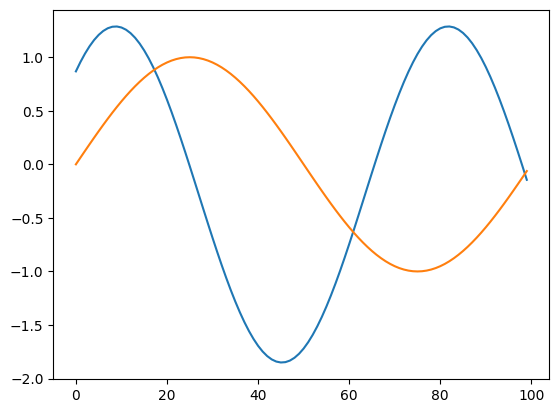

In [64]:
plt.plot(pred[:, 0, 0, 0])
plt.plot(target[:,0, 0, 0])

In [73]:
times = np.linspace(0,1, 100, dtype=np.float64)
# times = np.expand_dims(times, axis=(1,2,3))

vals = np.cos(10*2*np.pi*times) + np.cos(20*2* np.pi * times)
vals = np.expand_dims(vals, axis=(1,2,3))
t_size = np.ones((100, 1, 128, 128), dtype=np.float64)
target = t_size * vals

# noise = np.random.normal(scale=0.2, size=(100, 1, 128, 128))
# vals = vals + noise

print(target.shape)
print(times.shape)

(100, 1, 128, 128)
(100,)


In [74]:

xformed = fft(vals, axis=0)
xformed_abs = np.abs(xformed)

ixformed = ifft(xformed, axis=0)

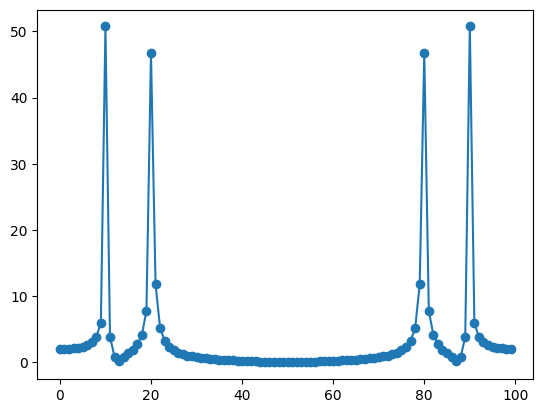

In [75]:
plt.plot(xformed_abs[:, 0, 0, 0], marker="o")

In [78]:
xformed_abs[0:30, 0, 0, 0]

array([ 2.        ,  2.01205831,  2.04949286,  2.11647176,  2.22149043,
        2.38086461,  2.62759769,  3.03756517,  3.83051047,  6.021117  ,
       50.73515638,  3.87458196,  0.85984544,  0.1842654 ,  0.81855681,
        1.35596286,  1.94557354,  2.75604623,  4.17356602,  7.79827576,
       46.70422302, 11.79492958,  5.18839129,  3.28841299,  2.38024058,
        1.84535453,  1.4915569 ,  1.23950731,  1.05041752,  0.90303979])

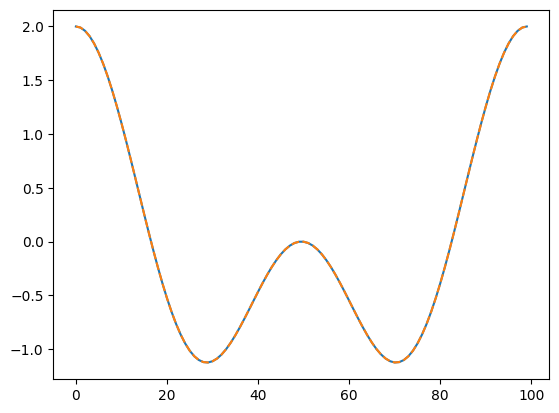

In [72]:
plt.plot(vals[:, 0, 0, 0])
plt.plot(ixformed[:, 0, 0, 0], ls="--")